# 5.1 AB test

Предоставлены данные АА-теста с '2023-02-23' по '2023-03-01'. Необходимо сделать симуляцию, как будто проведены 10 000 АА-тестов. На каждой итерации необходимо сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

## Загрузка данных

In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import numpy as np
import scipy.stats as stats

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230320'
}

query = """
SELECT 
    user_id,
    countIf(user_id, action = 'view') AS views,
    countIf(user_id, action = 'like') AS likes,
    exp_group,
    likes / views AS ctr
FROM
    {db}.feed_actions
WHERE toDate(time) BETWEEN '2023-02-23' AND '2023-03-01'
  AND exp_group in (2, 3)
GROUP BY user_id, exp_group 
"""

# сохранение данных в df
df = ph.read_clickhouse(query, connection=connection)  

In [3]:
# просмотр df
df.head()

,user_id,views,likes,exp_group,ctr
0,115383,36,11,3,0.305556
1,123580,92,15,3,0.163043
2,131473,148,26,2,0.175676
3,23985,66,12,2,0.181818
4,24523,120,17,2,0.141667


In [4]:
# основная информация о df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17049 entries, 0 to 17048
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    17049 non-null  uint32 
 1   views      17049 non-null  uint64 
 2   likes      17049 non-null  uint64 
 3   exp_group  17049 non-null  int8   
 4   ctr        17049 non-null  float64
dtypes: float64(1), int8(1), uint32(1), uint64(2)
memory usage: 483.0 KB


In [5]:
# проверка распределения количества пользователей в группах
df.groupby('exp_group').count()

,user_id,views,likes,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


Количество пользователей в группе 2 = 8 480 чел., в группе 3 = 8 569 чел.

## Распределение CTR групп на графике

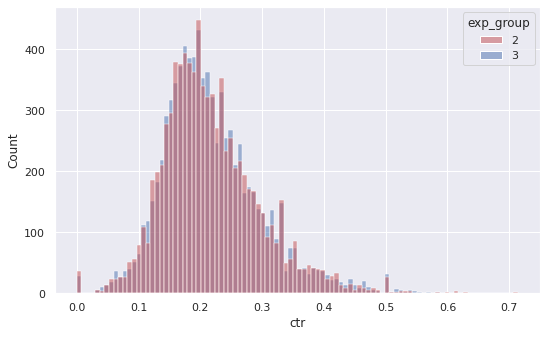

In [6]:
# график распределения групп в seaborn 
sns.set(rc={'figure.figsize':(8.7,5.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False) 

На графике видно, что CTR групп распределен нормально. однако необходимо проверить это на тестах

## Проведение АА теста

In [7]:
# t-тест на всех данных
stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-0.7393597924958364, pvalue=0.45969873156476293)

In [8]:
# проведение 10 000 экспериментов на случайных наборах из 500 юзеров на тестовых группах 2 и 3 

# создание массива для хранения результатов
p_values = []

# запуск симуляции 10000 АА-тестов
for i in range(10000):
    # отбор случайных 500 юзеров из 2 и 3 группы, без повторений
    group2 = df[df.exp_group == 2].sample(n=500, replace=False)
    group3 = df[df.exp_group == 3].sample(n=500, replace=False)
    
    # объединение двух выборок в одну
    sample = pd.concat([group2, group3], axis=0)
    
    # проведение t-test
    t_stat, p_val = stats.ttest_ind(sample[sample.exp_group == 2].ctr,
                              sample[sample.exp_group == 3].ctr,
                              equal_var=False)
    
    # сохранение p-value в массив
    p_values.append(p_val)

In [9]:
# проверка правильности работы системы сплитования выборки на 500 юзеров
sample.groupby('exp_group').count()

,user_id,views,likes,ctr
exp_group,,,,
2,500,500,500,500
3,500,500,500,500


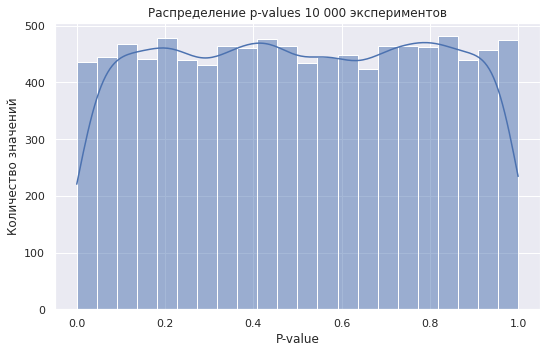

In [10]:
# построение гистограммы распределения p-values
sns.histplot(p_values, kde= True).set(title='Распределение p-values 10 000 экспериментов', xlabel='P-value', ylabel = 'Количество значений');

Распределение результатов теста получилось равномерным

In [11]:
# расчет процента p-values, оказавшихся меньше или равными 0.05 по результатам эксперимента
p_val_005 = round ((sum(x<=0.05 for x in p_values) / len(p_values))*100, 2)
print(f'{p_val_005}% значений p-values <= 0.05')

4.79% значений p-values <= 0.05


**Вывод по проведенному АА тесту:**

На основании полученного значения делаем вывод, что только в приблизительно 5% случаев удалось отклонить нулевую гиппотезу (т.е. при которой ключевые метрки в двух выборках равны). Следовательно наша система сплитования работает корректно.